# 미니 경진대회 - 선박 도장 품질 분류

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from collections import Counter
import matplotlib.font_manager as fm
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 시스템에 설치된 폰트 중 나눔고딕(NanumGothic) 찾기
# 만약 없다면, 다른 한글 폰트(예: Malgun Gothic)로 대체할 수 있습니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 일반적인 리눅스 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

ROOT = Path("/mnt/elice/dataset")

In [3]:
# 제출할 때마다 score가 흔들리는 걸 방지하기 위해 전체 무작위성 통제 함수를 추가
seed=202
def set_seed(seed):
    """모든 무작위성을 통제하는 함수"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # GPU 사용 시 필요
    np.random.seed(seed)
    random.seed(seed)
    # CUDA에 대한 추가 설정 (GPU 사용 시 필요)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed) 

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [4]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (224, 224)

# 이미지 데이터 탐색
## 이미지 크기 확인

이미지마다 크기가 다른 경우가 많다.

모델에 넣기 전에 모든 이미지를 동일한 크기로 맞춰줘야 하는데 

그 전에 이미지 크기가 어떤지 확인해보자. 

In [5]:
image_sizes = [] # 이미지 크기를 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder in folder_to_label:
    folder_path = ROOT / folder
    # rglob("*")로 하위 폴더까지 모든 파일 탐색
    for p in folder_path.rglob("*"):
        # 파일 확장자가 이미지 확장자에 포함되는지 확인
        if p.suffix.lower() in IMG_EXTS:
            try:
                # PIL을 사용해 이미지 파일 열기
                with Image.open(p) as img:
                    # 이미지의 (가로, 세로) 크기만 가져와서 리스트에 추가
                    image_sizes.append(img.size)
            except IOError:
                # 파일이 손상되었거나 이미지가 아닐 경우 예외 처리
                print(f"이미지 파일을 여는 데 실패했습니다: {p}")
                continue

#---
### 📊 결과 분석

print(f"총 이미지 개수: {len(image_sizes)}")
print("="*30)

# 고유한 이미지 크기 종류
unique_sizes = sorted(list(set(image_sizes)))
print(f"고유한 이미지 크기 종류: {len(unique_sizes)}개")
print(f"모든 고유 크기: {unique_sizes}")
print("="*30)

# 가장 작은 크기와 가장 큰 크기
if image_sizes:
    print(f"가장 작은 이미지 크기: {min(image_sizes)}")
    print(f"가장 큰 이미지 크기: {max(image_sizes)}")


총 이미지 개수: 1200
고유한 이미지 크기 종류: 17개
모든 고유 크기: [(1272, 2828), (1284, 2851), (1320, 2828), (1349, 2851), (1592, 2828), (2121, 2828), (2138, 2138), (2138, 2851), (2331, 1311), (2542, 2121), (2828, 1272), (2828, 1320), (2828, 1592), (2828, 2121), (2851, 1284), (2851, 1349), (2851, 2138)]
가장 작은 이미지 크기: (1272, 2828)
가장 큰 이미지 크기: (2851, 2138)


역시 이미지의 크기가 제각각이다. 


총 1200장인데 17가지의 다른 크기가 있음.


✅ 전처리 과정에서 Resize 필수


## 이미지 클래스별 분포 확인


이제 각 클래스에 이미지가 몇장 있는지, 즉, 균형 잡혀있는지 파악해야 함

In [6]:
y = [] # 라벨을 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    for p in folder_path.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            y.append(label)

# y 리스트에 있는 각 라벨의 개수를 센다
class_counts = Counter(y)

# 결과 출력하기
print(class_counts)

Counter({'양품': 400, '스크래치': 200, '부풀음': 200, '도막떨어짐': 200, '이물질포함': 200})


데이터가 '양품'에 쏠려있다.

학습 시에 쏠려서 학습되고 다른 클래스를 제대로 인식하지 못할 수 있음.

이렇게 되면 양품을 맞히는 비율이 높아서 전체 정확도만 높게 나오는 문제가 발생할 수 있음

> ✅ 데이터 증강이나 오버샘플링 필요

## 이미지 샘플 시각화
이미지 화질, 밝기, 배경의 특징 확인해보자.

잘못 라벨링된 이미지가 있을 수도 있으니 확인해볼 것.

### 파일경로 - 라벨매핑
데이터 폴더를 탐색해서 각 라벨에 해당하는 이미지 파일들의 경로를 리스트로 정리하기

In [7]:
label_to_paths = {}
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    # 파일 확장자가 이미지인 파일들의 경로만 리스트에 담기
    image_paths = [p for p in folder_path.rglob("*") if p.suffix.lower() in IMG_EXTS]
    # 라벨을 키(key), 이미지 경로 리스트를 값(value)으로 저장
    label_to_paths[label] = image_paths

### 이미지 샘플 시각화
label_to_paths 딕셔너리를 사용해 각 클래스별로 무작위 샘플을 뽑아 보여줄 것임.

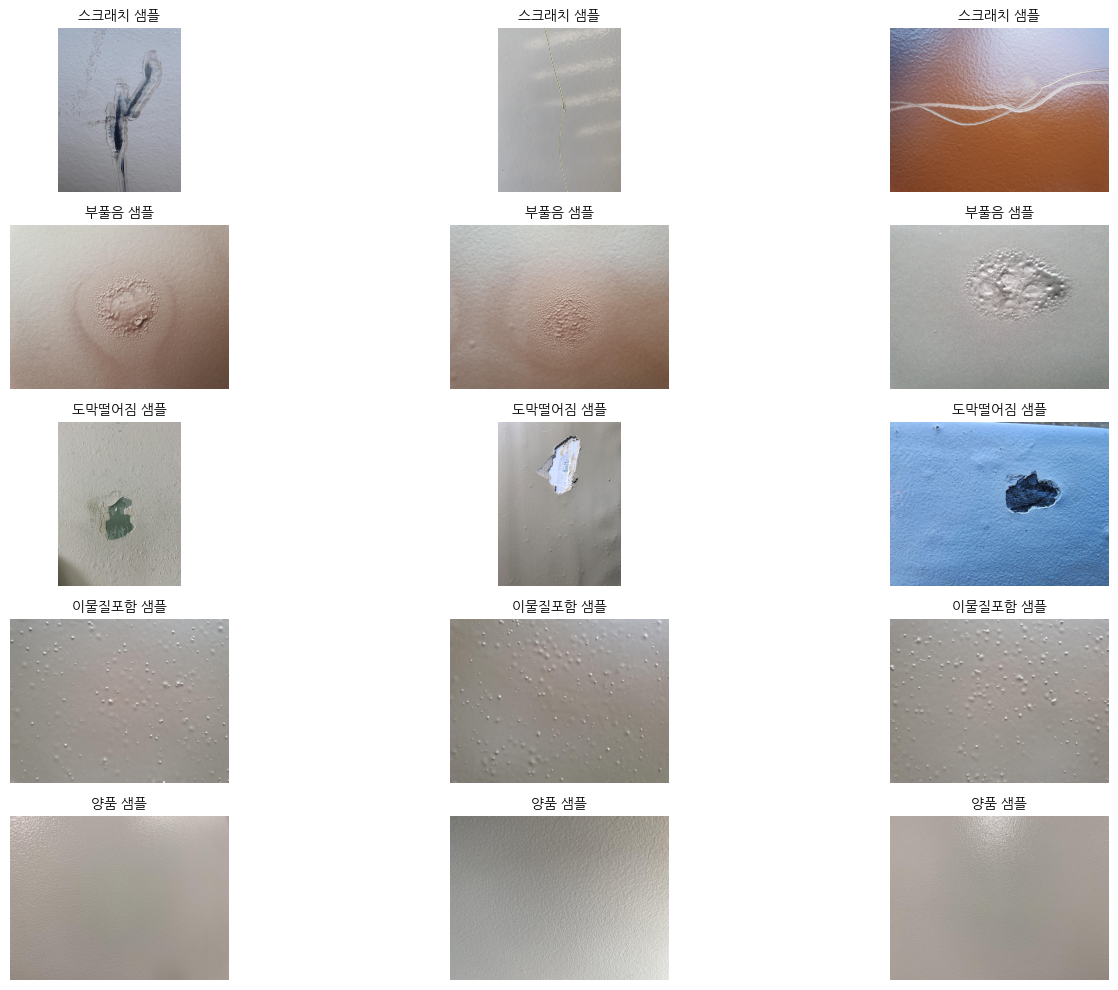

In [8]:
# 시각화 설정
plt.figure(figsize=(15, 10))  # 그래프 전체 크기 설정
num_samples = 3  # 각 클래스에서 보여줄 이미지 개수

# 각 라벨(클래스)별로 이미지 시각화
for i, (label, paths) in enumerate(label_to_paths.items()):
    # 현재 라벨에 해당하는 이미지 경로들에서 num_samples 개수만큼 무작위로 선택
    random_paths = random.sample(paths, min(num_samples, len(paths)))

    # 선택된 이미지를 하나씩 서브플롯(subplot)에 그리기
    for j, img_path in enumerate(random_paths):
        # subplot 위치 지정 (총 라벨 수, 각 라벨당 이미지 수, 현재 위치)
        ax = plt.subplot(len(label_to_paths), num_samples, i * num_samples + j + 1)
        
        # 이미지 열기 및 표시
        img = Image.open(img_path)
        plt.imshow(img)
        
        # 제목 설정 및 축 제거
        plt.title(f"{label} 샘플", fontsize=10)
        plt.axis("off")

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

1. 라벨링 오류: 잘못 분류된 이미지가 있는지 확인 필요
> 학습 후 오류 분석 

2. 데이터 특성: 특정 패턴이 반복되는지 확인 필요
> 데이터 증강 기술 이용 필요: 회전 및 뒤집기, 색상 왜곡, 노이즈 추가

3. 배경이나 조명이 너무 다양해서 학습에 방해가 될 만한 요소는 없는지 확인 필요.
> 데이터 증강 기술 이용 필요: 밝기/대비 조절, 랜덤 크롭, 랜덤 이레이징 

--------------------------
'이물질 포함'이나 '부풀음' 클래스의 반복적인 패턴,
다양한 배경, 조명 문제가 보임
> ✅ 데이터 증강 기술 이용 필요! 

## 통합 전처리 파이프라인 구축 

:코드가 깔끔해질 수 있게 모든 전처리 과정을 하나로 묶자.

In [9]:
# ImageNet 데이터셋의 평균과 표준편차 (딥러닝에서 일반적으로 사용)
# 이 값은 모델의 학습 효율을 높여준다.
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# 1. 학습용 데이터 전처리 파이프라인 (Data Augmentation 포함)
train_transform = transforms.Compose([
    # ✅ 이미지 크기 통일 (다양한 크기 문제 해결)
    transforms.Resize(IMG_SIZE),
    
    # ✅ 조명/배경 문제, 과적합을 막기 위한 데이터 증강
    transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 좌우 반전
    transforms.RandomVerticalFlip(),    # 이미지를 무작위로 상하 반전
    transforms.RandomRotation(30),       # 이미지를 -30도 ~ +30도 사이에서 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 밝기, 대비 등 무작위 조절
    
    # 이미지를 PyTorch 텐서로 변환 (0-255 -> 0-1)
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 검증/테스트용 데이터 전처리 파이프라인 (Data Augmentation 없음)
val_transform = transforms.Compose([
    # 이미지 크기 통일
    transforms.Resize(IMG_SIZE),
    
    # 이미지를 PyTorch 텐서로 변환
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

## 전략적인 데이터 증강
: 데이터 불균형과 배경/조명 문제 해결을 위함.

In [10]:
# 1. 다수 클래스 ('양품')를 위한 전처리
# ✅ 증강을 최소화하여 데이터가 과하게 변형되는 것을 방지
majority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 소수 클래스를 위한 전처리 (✅ 더 공격적인 증강 적용)
minority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomVerticalFlip(),    # 상하 반전
    transforms.RandomRotation(30),      # 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 조명, 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])


# 3. X, y 리스트 초기화
X = [] # 이미지 데이터를 저장할 리스트
y = [] # 라벨을 저장할 리스트

# 4. 이미지를 로드하고 전처리하여 리스트에 추가
for folder, label in folder_to_label.items():
    d = ROOT / folder
    for p in d.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                img = Image.open(p).convert("RGB") # 이미지를 RGB로 로드
                
                # 라벨에 따라 다른 파이프라인 적용
                if label == "양품":
                    img_transformed = majority_transform(img)
                else:
                    img_transformed = minority_transform(img)
                
                # 변환된 이미지를 X 리스트에 추가
                X.append(img_transformed)
                # 라벨을 y 리스트에 추가
                y.append(label)
                
            except IOError:
                print(f"이미지를 여는 데 실패했습니다: {p}")
                continue

# X 리스트에 데이터가 PyTorch 텐서로 저장된다.
print(f"X 리스트에 저장된 이미지 데이터 개수: {len(X)}")
print(f"y 리스트에 저장된 라벨 개수: {len(y)}")
print("데이터 로딩 및 전처리 완료!")

X 리스트에 저장된 이미지 데이터 개수: 1200
y 리스트에 저장된 라벨 개수: 1200
데이터 로딩 및 전처리 완료!


# 데이터 분할

In [11]:
# 1. y 리스트의 문자열 라벨을 숫자로 변환
unique_labels = sorted(list(set(y)))
label_to_num = {label: i for i, label in enumerate(unique_labels)}
y_num = [label_to_num[label] for label in y]

# 2. X는 리스트 형태이므로 배열로 변환
X = np.array(X)
y = np.array(y_num)

# 3. 학습(Train) & 테스트(Test) 세트로 먼저 분할
# test_size=0.2는 전체 데이터의 20%를 테스트 세트로 사용하겠다는 의미
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 학습 세트를 다시 학습(Train) & 검증(Validation) 세트로 분할
# test_size=0.25는 남은 학습 데이터(80%)의 25%이므로, 전체 데이터의 20%가 검증 세트가 됨
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 각 세트의 데이터 개수 확인
print("="*30)
print(f"학습 세트 크기: {X_train.shape[0]}개")
print(f"검증 세트 크기: {X_val.shape[0]}개")
print(f"테스트 세트 크기: {X_test.shape[0]}개")
print("="*30)

학습 세트 크기: 720개
검증 세트 크기: 240개
테스트 세트 크기: 240개


## 모델 학습

ResNet으로 첫번째 모델을 선택한 이유 
- 전이 학습의 이점 : 적은 데이터로도 높은 성늘을 달성 할 수 있음
- 초보자에게 적합한 범용성 : 데이터셋 규모나 컴퓨팅 환경에 맞춰 다양한 크기의 모델을 선택 가능.

------------------------------------ 
1. ResNet(F1-score: 0.5338)
- param.requires_grad = False
- lr=0.001

2.ResNet(F1-score: 0.8177)
- param.requires_grad = False > True
- lr=0.001 > 0.0001

3.ResNet(F1-score:0.8731)
- param.requires_grad = True
- lr=0.0001
- optimizer=Adam > AdamW
- 스케줄러 추가: ReduceLROnPlateau()
- epochs: 10 > 20

4.ResNet(F1-socre:0.5000 이하)
- mixup 추가 > 값이 매우 떨어짐, 모호한 데이터가 만들어졌을 수 있음.

5.ResNet(F1-socre:0.7804)
- mixup 제거, cutmix 추가 

> ResNet 성능 개선에 한계를 느껴서 모델을 변경하겠음.
-----------------------------
<모델 변경>

1.EfficientNet-B0(F1-score:0.7831)
- cutmix > 값이 크게 변한 게 없어서 제거 해보겠음

2.EfficientNet-B0(F1-score:0.9017)
- cutmix 제거 > cutmix때문에 전체적인 학습패턴을 못보고 있었던듯

3.EfficientNet(앙상블: seed=42, 101, 202)(F1-score: 0.8732)
- 더 낮아짐.. 기본적으로 비슷한 방식으로 학습해서 비슷한 특징을 찾아냈을 듯..

4.EfficientNet(F1-score: 0.9638)
- 앙상블 제거
- 해상도: 128 x 128 > 224 x 224(해당 모델은 해상도 224 x 224에서 가장 좋은 효능을 냄)

> EfficientNet 성능 개선에 한계를 느껴 모델을 변경하겠음.

------------------------------------
<모델 변경> 앙상블 

#### EfficientNet B0 & Efficient-B2 & Efficient-B4
: 값에 큰 변화 없었음

#### EfficientNet B0 & ResNet50
: 값에 큰 변화 없었음

>> 최종: EfficientNet 채택..
더 해보고 싶었지만 시간 관계상 마무리 지어야하는 아쉬움이 잇었음..
Optuna도 써보지 못한게 아쉬움 

In [12]:
# 1. 사전 학습된 EfficientNet-B0 모델 불러오기
# weights='EfficientNet_B0_Weights.DEFAULT'를 사용해 최신 사전 학습 가중치를 가져옵니다.
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# 2. 전이 학습을 위해 마지막 레이어 수정
# EfficientNet은 마지막 레이어 구조가 ResNet과 조금 다름.
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 5) # 클래스 개수 5개로 설정

# 3. 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("EfficientNet 모델 구축 완료!")
print(f"모델을 다음 장치로 옮겼습니다: {device}")

EfficientNet 모델 구축 완료!
모델을 다음 장치로 옮겼습니다: cuda


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 데이터를 텐서로 변환
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# 데이터셋을 TensorDataset으로 묶기
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor) 

# 데이터로더 생성 (데이터를 배치 단위로 불러오는 역할)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 1. 손실 함수와 옵티마이저 정의
# 손실 함수: 예측값과 실제값의 차이를 계산 (이미지 분류에는 CrossEntropyLoss가 적합)
criterion = nn.CrossEntropyLoss()
# 옵티마이저: 손실을 줄이기 위해 모델의 가중치를 업데이트
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 2. 학습률 스케줄러 정의
# ReduceLROnPlateau는 훈련 시 특정 지표(여기서는 검증 손실)가 개선되지 않을 때 학습률을 자동으로 줄여줌.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 3. 모델 학습을 위한 반복문 (Training Loop)
num_epochs = 20  
min_val_loss = float('inf')  # 가장 낮은 검증 손실을 저장할 변수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    # --- 학습 단계 ---
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- 검증 단계 ---
    model.eval()  # 모델을 평가 모드로 설정
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    # 각 에포크별 손실 출력
    train_loss = running_loss / len(train_loader)
    val_loss = val_running_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], 학습 손실: {train_loss:.4f}, 검증 손실: {val_loss:.4f}")

    # ★ 학습률 스케줄러 단계 (검증 손실에 따라 학습률을 조정)
    # val_loss가 3번 연속 개선되지 않으면 학습률이 자동으로 줄어듬.
    scheduler.step(val_loss)

    # ★ 최고 성능 모델 저장
    # 검증 손실이 최저 손실보다 낮으면 모델 가중치를 저장
    if val_loss < min_val_loss:
        min_val_loss = val_loss
    # 시드 값을 파일 이름에 포함시켜 저장
        torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
        print(f"최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_{seed}.pth")
        
print('학습 완료!')

Epoch [1/20], 학습 손실: 1.2320, 검증 손실: 0.7096
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [2/20], 학습 손실: 0.5354, 검증 손실: 0.2637
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [3/20], 학습 손실: 0.2179, 검증 손실: 0.1492
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [4/20], 학습 손실: 0.1107, 검증 손실: 0.0987
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [5/20], 학습 손실: 0.0610, 검증 손실: 0.0724
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [6/20], 학습 손실: 0.0341, 검증 손실: 0.0669
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [7/20], 학습 손실: 0.0419, 검증 손실: 0.0503
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [8/20], 학습 손실: 0.0269, 검증 손실: 0.0574
Epoch [9/20], 학습 손실: 0.0210, 검증 손실: 0.0443
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [10/20], 학습 손실: 0.0184, 검증 손실: 0.0466
Epoch [11/20], 학습 손실: 0.0301, 검증 손실: 0.0393
최고 검증 손실 달성, 모델 가중치 저장! 파일명: best_model_seed_202.pth
Epoch [12/20], 학습 손실: 0.0199, 검증 손실: 0.0625
Epoc

# 모델 평가

In [14]:
# 모델을 평가 모드로 설정
model.eval()

# 손실 함수 정의 (학습 때와 동일)
criterion = nn.CrossEntropyLoss()

# 모델 평가 함수 정의
def evaluate_model(model, data_loader, device, criterion):
    # 총 예측 수, 맞힌 수, 손실을 저장
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    # ★ F1-Score 계산을 위해 모든 라벨과 예측값을 저장할 리스트 추가
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 예측 결과 확인
            _, predicted = torch.max(outputs.data, 1)

            # ★ 모든 라벨과 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    # 루프가 끝난 후 최종 지표 계산
    avg_loss = running_loss / len(data_loader)
    accuracy = total_correct / total_samples

    # ★ 정밀도, 재현율, F1-Score 계산
    # average='macro'로 각 클래스의 점수를 동등하게 평균낸다.
    # 리더보드의 f1-score랑 비슷한 숫자를 찾아보려고 average 를 바꿔봤지만 못 찾았음.
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='micro', zero_division=0)

    # ★ 모든 지표를 반환
    return avg_loss, accuracy, precision, recall, f1

# 1. 검증 세트 평가 (반환값 수정)
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, device, criterion)
print(f"검증 손실(Validation Loss): {val_loss:.4f}")
print(f"검증 정확도(Validation Accuracy): {val_accuracy:.4f}")
print(f"검증 정밀도(Validation Precision): {val_precision:.4f}")
print(f"검증 재현율(Validation Recall): {val_recall:.4f}")
print(f"검증 F1-Score: {val_f1:.4f}")

# 2. 테스트 세트 평가 (반환값 수정)
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, device, criterion)
print(f"테스트 손실(Test Loss): {test_loss:.4f}")
print(f"테스트 정확도(Test Accuracy): {test_accuracy:.4f}")
print(f"테스트 정밀도(Test Precision): {test_precision:.4f}")
print(f"테스트 재현율(Test Recall): {test_recall:.4f}")
print(f"테스트 F1-Score: {test_f1:.4f}")

검증 손실(Validation Loss): 0.0496
검증 정확도(Validation Accuracy): 0.9833
검증 정밀도(Validation Precision): 0.9772
검증 재현율(Validation Recall): 0.9791
검증 F1-Score: 0.9833
테스트 손실(Test Loss): 0.0324
테스트 정확도(Test Accuracy): 0.9958
테스트 정밀도(Test Precision): 0.9944
테스트 재현율(Test Recall): 0.9949
테스트 F1-Score: 0.9958


## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 우리는 그 중에서 **F1 Score**를 사용한다. 

- TTA(Test-Time Augmentation)
: 학습할 때처럼 예측할 때도 데이터를 증강(변형)해서 모델에 입력하고 그 결과를 평균 내는 기법
1. 예측의 안정성 향상: 모델이 특정 방향에 치우쳐서 예측하는 편향을 줄여줌
2. 정확도 소폭 상승: 여러 번의 예측 결과를 평균 내기 때문에, 단일 예측에서 발생할 수 있는 사소한 오류들을 보완

In [15]:
# --- 이전에 정의한 변수들을 가져옵니다 ---
ROOT = Path("/mnt/elice/dataset/")
SUBMIT_DIR = ROOT / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (224, 224)

# 1. 모델과 장치 불러오기
# model.to(device)와 model.eval() 상태여야 합니다.

# 2. 전처리 파이프라인 정의
submit_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. 라벨 맵핑을 위한 딕셔너리
num_to_label = {0: '도막떨어짐', 1: '부풀음', 2: '스크래치', 3: '양품', 4: '이물질포함'}

# 4. ✅✅ TTA를 적용한 예측 수행 및 결과 저장
filenames, labels = [], []
model.eval() # 모델을 평가 모드로 전환
num_tta = 5  # TTA 횟수 (5번 반복)

with torch.no_grad(): # 경사 계산 비활성화
    for p in SUBMIT_DIR.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            # TTA를 위한 예측값 저장 리스트
            tta_preds = []

            for _ in range(num_tta):
                # 1. 이미지 불러오기 및 TTA 변형
                im = Image.open(p).convert("RGB")
                
                # ★ TTA 적용 예시: 수평 뒤집기
                if random.random() > 0.5:
                    im = transforms.functional.hflip(im)
                
                im_tensor = submit_transform(im).unsqueeze(0).to(device)

                # 2. 예측
                output = model(im_tensor)
                tta_preds.append(output)
            
            # 3. TTA 예측 결과들을 평균내서 최종 예측
            avg_output = torch.mean(torch.stack(tta_preds), dim=0)
            _, predicted = torch.max(avg_output, 1)

            # 4. 예측값(숫자)을 라벨(문자열)로 변환
            predicted_label = num_to_label[predicted.item()]

            filenames.append(p.name)
            labels.append(predicted_label)
            
# 5. 제출용 데이터프레임 생성 및 CSV 저장
df_submit = pd.DataFrame({
    "filename": filenames,
    "label": labels
})

df_submit = df_submit.sort_values(by="filename")
df_submit.to_csv("./submission.csv", index=False)

print("submission.csv 파일이 성공적으로 저장되었습니다.")
df_submit.head()

submission.csv 파일이 성공적으로 저장되었습니다.


,filename,label
850,00001.jpg,도막떨어짐
238,00002.jpg,도막떨어짐
381,00003.jpg,스크래치
404,00004.jpg,스크래치
231,00005.jpg,양품


### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일